In [1]:
%matplotlib inline
import sys
sys.path.append('../../stlcg_karen/src')
sys.path.append('../expert_demo_ros/src/utils')
import stlcg
import matplotlib.pyplot as plt


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
import pickle
import torch
import pickle
import scipy.io as sio
import tensorflow as tf

from torch_interpolations.torch_interpolations.multilinear import RegularGridInterpolator
from torch.utils.tensorboard import SummaryWriter
from environment import *
from src.learning import *

In [2]:
value = sio.loadmat('../hji/data/value.mat');
deriv_value = sio.loadmat('../hji/data/deriv_value.mat');
V = value['data'];
dV = [deriv_value['derivC'][i][0] for i in range(4)];
g = sio.loadmat('../hji/data/grid.mat')['grid'];


In [3]:

values = torch.tensor(V[:,:,:,:,-1]).float()
points = [torch.from_numpy(g[i][0].flatten()).float() for i in range(4)]
value_interp = RegularGridInterpolator(points, values)
deriv_interp = [RegularGridInterpolator(points, torch.tensor(dV[i][:,:,:,:,-1]).float()) for i in range(4)]

In [4]:
def plot_xy_from_tensor(x_train, fig=None):
    xy = x_train.squeeze().detach().numpy()[:,:2]
    if fig is None:
        fig = plt.figure(figsize=(10,8))
    plt.plot(xy[:,0], xy[:,1])
    plt.scatter(xy[:,0], xy[:,1])
    return fig

In [5]:

params = {  "covers": [Box([0., 6.],[4, 8.]), Box([6., 2.],[10.0, 4.0])],
            "obstacles": [Circle([7., 7.], 2.0)],
            "initial": Box([-1., -1.],[1., 1.]),
            "final": Box([9.0, 9.0],[11.0, 11.0])
       }

cov_env = CoverageEnv(params)
draw_params = {"initial": {"color": "lightskyblue", "fill": True, "alpha": 0.5}, "final": {"color": "coral", "fill": True, "alpha": 0.5}, "covers": {"color": "black", "fill": False}, "obs": {"color": "red", "fill": True, "alpha": 0.5} }


In [6]:
# prepare data and standardize

# original data
x_train_, u_train_, stats = prepare_data("../hji/data/expert_traj_train.npy")
x_eval_, u_eval_, _ = prepare_data("../hji/data/expert_traj_eval.npy")

ic_train_ = torch.Tensor(InitialConditionDataset(2048)).float()
ic_eval_ = torch.tensor(initial_conditions(128)).float()


# standardized data
x_train = standardize_data(x_train_, stats[0][:,:,:4], stats[1][:,:,:4])
u_train = standardize_data(u_train_, stats[0][:,:,4:], stats[1][:,:,4:])

x_eval = standardize_data(x_eval_, stats[0][:,:,:4], stats[1][:,:,:4])
u_eval = standardize_data(u_eval_, stats[0][:,:,4:], stats[1][:,:,4:])

ic_train = standardize_data(ic_train_, stats[0][:,:,:4], stats[1][:,:,:4])
ic_eval = standardize_data(ic_eval_, stats[0][:,:,:4], stats[1][:,:,:4])


ic_trainloader = torch.utils.data.DataLoader(ic_train, batch_size=32, shuffle=True)


/home/karen/projects/stlcg_ctrl_syn/ctrl_syn/torch_interpolations/torch_interpolations/multilinear.py:39: UserWarning: input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible (Triggered internally at  /pytorch/aten/src/ATen/native/BucketizationUtils.h:20.)
  idx_right = torch.bucketize(x, p)


In [7]:
stl_traj = x_train.permute([1,0,2]).flip(1)
circle =  cov_env.obs[0]


def outside_circle_stl(signal, circle):
    d2 = stlcg.Expression('d2_to_center', (signal[:,:,:2] - torch.tensor(circle.center).unsqueeze(0).unsqueeze(0)).pow(2).sum(-1, keepdim=True))
    return stlcg.Always(subformula = d2 > circle.radius), d2
    

def in_box_stl(signal, box):
    x = stlcg.Expression('x', signal[:,:,:1])
    y = stlcg.Expression('y', signal[:,:,1:2])
    return ((x > box.lower[0]) & (y > box.lower[1])) & ((x < box.upper[0]) & (y < box.upper[1])), ((x, y),(x, y))



obs_avoid, obs_avoid_input = outside_circle_stl(stl_traj, cov_env.obs[0])
in_box, in_box_input = in_box_stl(stl_traj, cov_env.final)
end_goal = stlcg.Eventually(subformula=stlcg.Always(subformula=in_box))


formula = obs_avoid & end_goal


def get_formula_input(signal):
    d2 = stlcg.Expression('d2_to_center', (signal[:,:,:2] - torch.tensor(circle.center).unsqueeze(0).unsqueeze(0)).pow(2).sum(-1, keepdim=True))
    x = stlcg.Expression('x', signal[:,:,:1])
    y = stlcg.Expression('y', signal[:,:,1:2])
    return (d2, ((x, y),(x, y)))

formula(get_formula_input(stl_traj))


tensor([[[-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606]]])

In [8]:
state_dim = 4
ctrl_dim = 2
hidden_dim = 32

a_min=-3
a_max=3
delta_min=-0.344
delta_max=0.344


policy = STLPolicy(kinematic_bicycle, state_dim, ctrl_dim, hidden_dim, stats)
optimizer = torch.optim.Adam(policy.parameters(), lr=0.001)


# testing functions
x_future, u_future = policy.propagate_n(10, x_train[:1,:,:])

policy.HJI_loss(x_future)
policy.STL_loss(x_future, formula, get_formula_input, scale=-1)

tensor(9.5039, grad_fn=<MeanBackward0>)

In [9]:
xl, ul = policy.state_control_loss(x_train, x_train, u_train, teacher_training=0.1)

In [11]:
writer = SummaryWriter()

In [ ]:
T = x_train.shape[0]+4
weight_recon = 1.0
weight_ctrl = 0.7
weight_HJI = 0.1
weight_stl = 0.1
b = 50
c = 10
teacher_training = lambda ep: np.exp(ep/b - c) / (1 + np.exp(ep/b - c))


iteration = 0
epochs = 1000


for ep in range(epochs):
    for (i,ic_) in enumerate(ic_trainloader):
        ic = ic_.permute([1,0,2]).float()
        policy.train()
        optimizer.zero_grad()
        # reconstruct the expert policy
        loss_state, loss_ctrl = policy.state_control_loss(x_train, x_train, u_train, teacher_training=teacher_training(ep))
        loss_recon = loss_state + weight_ctrl * loss_ctrl
        
        # with new ICs, propagate the trajectories and keep them inside the reachable set
        x_future, u_future = policy.propagate_n(T, ic)
        complete_traj = policy.join_partial_future_signal(ic, x_future)
        loss_HJI = policy.HJI_loss(complete_traj)
        
        # stl loss
        loss_stl = policy.STL_loss(complete_traj, formula, get_formula_input, scale=-1)
        
        # total loss
        loss = weight_recon * loss_recon + weight_HJI * loss_HJI + weight_stl * loss_stl

        writer.add_scalar('train/state', loss_state, iteration)
        writer.add_scalar('train/ctrl', loss_ctrl, iteration)
        writer.add_scalar('train/HJI', loss_HJI, iteration)
        writer.add_scalar('train/STL', loss_stl, iteration)
        writer.add_scalar('train/total', loss, iteration)

        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print("epoch %i\t loss: %.7f \t recon loss: %.3f \t HJI loss: %.3f \t STL loss: %.3f\n" %(i, loss, loss_recon, loss_HJI, loss_stl))
        iteration += 1
    
    # evaluation set
    policy.eval()
    loss_state, loss_ctrl = policy.state_control_loss(x_train, x_train, u_train)
    loss_recon = loss_state + weight_ctrl * loss_ctrl
    o, u = policy(x_eval)
    x_future, u_future = policy.propagate_n(T, ic_eval)
    complete_traj = policy.join_partial_future_signal(ic_eval, x_future)
    loss_HJI = policy.HJI_loss(complete_traj)
    loss_stl = policy.STL_loss(complete_traj, formula, get_formula_input, scale=-1)
    loss = weight_recon * loss_recon + weight_HJI * loss_HJI + weight_stl * loss_stl
    
    traj_np = unstandardize_data(complete_traj, stats[0][:,:,:state_dim], stats[1][:,:,:state_dim]).detach().numpy()
    x_future, u_future = policy.propagate_n(T, x_eval[:1,:,:])
    p = policy.join_partial_future_signal(x_train[:1,:,:], x_future)
    p = unstandardize_data(p, stats[0][:,:,:state_dim], stats[1][:,:,:state_dim]).squeeze().detach().numpy()
    
    
    print("epoch: %i    Loss: %.3f"%(ep, loss))
    writer.add_scalar('eval/state', loss_state, ep)
    writer.add_scalar('eval/ctrl', loss_ctrl, ep)
    writer.add_scalar('eval/HJI', loss_HJI, ep)
    writer.add_scalar('eval/STL', loss_stl, iteration)
    writer.add_scalar('eval/total', loss, ep)
    
    fig = plt.figure(figsize=(10,10))
    cov_env.draw2D(kwargs=draw_params)
    plt.axis("equal")
    plt.plot(x_train_.squeeze().numpy()[:,0], x_train_.squeeze().numpy()[:,1])
    plt.scatter(x_train_.squeeze().numpy()[:,0], x_train_.squeeze().numpy()[:,1])
    
    for j in range(ic_eval.shape[1]):
        plt.plot(traj_np[:,j,0], traj_np[:,j,1])
        plt.scatter(traj_np[:,j,0], traj_np[:,j,1])
        plt.plot(p[:,0], p[:,1])
        plt.scatter(p[:,0], p[:,1], marker='^', s=100)
    plt.xlim([-3, 12])
    plt.ylim([-3, 12])
    writer.add_figure('eval/trajectory', fig, ep)
    
    
    fig = plt.figure(figsize=(15,6))
    for k in [0,1]:
        plt.subplot(1,2,k+1)
        plt.plot(u_eval.squeeze().detach().numpy()[:,k])
        plt.plot(u.squeeze().detach().numpy()[:,k],'--')
        plt.grid()
        plt.xlim([0, 26])
        plt.ylim([-4,4])
    writer.add_figure('eval/controls', fig, ep)


epoch 0	 loss: 2.0154104 	 recon loss: 0.835 	 HJI loss: 1.524 	 STL loss: 10.285

epoch 10	 loss: 1.8623154 	 recon loss: 0.662 	 HJI loss: 2.035 	 STL loss: 9.968

epoch 20	 loss: 1.7013535 	 recon loss: 0.560 	 HJI loss: 1.752 	 STL loss: 9.665

epoch 30	 loss: 1.6183043 	 recon loss: 0.537 	 HJI loss: 0.910 	 STL loss: 9.903

epoch 40	 loss: 1.5264144 	 recon loss: 0.504 	 HJI loss: 0.737 	 STL loss: 9.486

epoch 50	 loss: 1.5002223 	 recon loss: 0.499 	 HJI loss: 0.247 	 STL loss: 9.762

epoch 60	 loss: 1.5341805 	 recon loss: 0.488 	 HJI loss: 0.918 	 STL loss: 9.549

epoch: 0    Loss: 2.207
epoch 0	 loss: 1.4734136 	 recon loss: 0.487 	 HJI loss: 0.348 	 STL loss: 9.515

epoch 10	 loss: 1.4859776 	 recon loss: 0.482 	 HJI loss: 0.442 	 STL loss: 9.602

epoch 20	 loss: 1.4884195 	 recon loss: 0.473 	 HJI loss: 0.681 	 STL loss: 9.475

epoch 30	 loss: 1.4283830 	 recon loss: 0.466 	 HJI loss: 0.059 	 STL loss: 9.564

epoch 40	 loss: 1.4280607 	 recon loss: 0.460 	 HJI loss: 0.200 

epoch 50	 loss: 0.7399816 	 recon loss: 0.185 	 HJI loss: 0.544 	 STL loss: 5.008

epoch 60	 loss: 0.6958227 	 recon loss: 0.184 	 HJI loss: 0.200 	 STL loss: 4.914

epoch: 13    Loss: 7.551
epoch 0	 loss: 0.6836790 	 recon loss: 0.184 	 HJI loss: 0.260 	 STL loss: 4.732

epoch 10	 loss: 0.6896707 	 recon loss: 0.184 	 HJI loss: 0.279 	 STL loss: 4.781

epoch 20	 loss: 0.7205735 	 recon loss: 0.183 	 HJI loss: 0.613 	 STL loss: 4.759

epoch 30	 loss: 0.6832830 	 recon loss: 0.183 	 HJI loss: 0.070 	 STL loss: 4.931

epoch 40	 loss: 0.6852051 	 recon loss: 0.182 	 HJI loss: 0.209 	 STL loss: 4.819

epoch 50	 loss: 0.7254392 	 recon loss: 0.182 	 HJI loss: 0.446 	 STL loss: 4.988

epoch 60	 loss: 0.6978766 	 recon loss: 0.182 	 HJI loss: 0.277 	 STL loss: 4.882

epoch: 14    Loss: 7.784
epoch 0	 loss: 0.7180256 	 recon loss: 0.182 	 HJI loss: 0.624 	 STL loss: 4.734

epoch 10	 loss: 0.6826257 	 recon loss: 0.182 	 HJI loss: 0.132 	 STL loss: 4.873

epoch 20	 loss: 0.6718197 	 recon loss:

epoch 20	 loss: 0.6406540 	 recon loss: 0.169 	 HJI loss: 0.115 	 STL loss: 4.602

epoch 30	 loss: 0.6446655 	 recon loss: 0.169 	 HJI loss: 0.084 	 STL loss: 4.675

epoch 40	 loss: 0.6519458 	 recon loss: 0.169 	 HJI loss: 0.135 	 STL loss: 4.697

epoch 50	 loss: 0.6593271 	 recon loss: 0.169 	 HJI loss: 0.198 	 STL loss: 4.707

epoch 60	 loss: 0.6431396 	 recon loss: 0.169 	 HJI loss: 0.001 	 STL loss: 4.743

epoch: 27    Loss: 8.601
epoch 0	 loss: 0.6409355 	 recon loss: 0.168 	 HJI loss: 0.144 	 STL loss: 4.581

epoch 10	 loss: 0.6329501 	 recon loss: 0.168 	 HJI loss: 0.000 	 STL loss: 4.646

epoch 20	 loss: 0.6322530 	 recon loss: 0.169 	 HJI loss: 0.059 	 STL loss: 4.579

epoch 30	 loss: 0.6268501 	 recon loss: 0.168 	 HJI loss: 0.000 	 STL loss: 4.585

epoch 40	 loss: 0.6447663 	 recon loss: 0.168 	 HJI loss: 0.188 	 STL loss: 4.577

epoch 50	 loss: 0.6418773 	 recon loss: 0.168 	 HJI loss: 0.158 	 STL loss: 4.579

epoch 60	 loss: 0.6522725 	 recon loss: 0.168 	 HJI loss: 0.029

epoch 60	 loss: 0.6445745 	 recon loss: 0.164 	 HJI loss: 0.136 	 STL loss: 4.672

epoch: 40    Loss: 8.772
epoch 0	 loss: 0.6334813 	 recon loss: 0.164 	 HJI loss: 0.110 	 STL loss: 4.589

epoch 10	 loss: 0.6349843 	 recon loss: 0.163 	 HJI loss: 0.090 	 STL loss: 4.626

epoch 20	 loss: 0.6301079 	 recon loss: 0.163 	 HJI loss: 0.065 	 STL loss: 4.603

epoch 30	 loss: 0.6357694 	 recon loss: 0.163 	 HJI loss: 0.112 	 STL loss: 4.614

epoch 40	 loss: 0.6394085 	 recon loss: 0.163 	 HJI loss: 0.127 	 STL loss: 4.633

epoch 50	 loss: 0.6316528 	 recon loss: 0.163 	 HJI loss: 0.000 	 STL loss: 4.685

epoch 60	 loss: 0.6302819 	 recon loss: 0.163 	 HJI loss: 0.047 	 STL loss: 4.622

epoch: 41    Loss: 8.800
epoch 0	 loss: 0.6257782 	 recon loss: 0.163 	 HJI loss: 0.090 	 STL loss: 4.535

epoch 10	 loss: 0.6306919 	 recon loss: 0.163 	 HJI loss: 0.043 	 STL loss: 4.633

epoch 20	 loss: 0.6249509 	 recon loss: 0.163 	 HJI loss: 0.032 	 STL loss: 4.585

epoch 30	 loss: 0.6329018 	 recon loss:

In [17]:
o, u = policy(x_train)
x_pred = policy.dynamics(x_train_, unstandardize_data(u, stats[0][:,:,4:], stats[1][:,:,4:]))

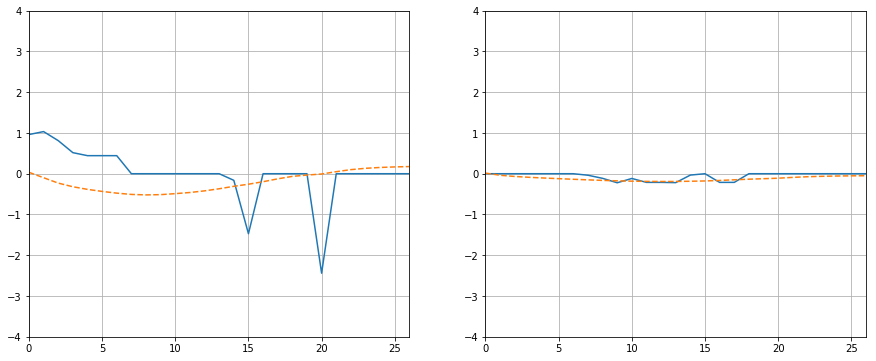

In [18]:
fig = plt.figure(figsize=(15,6))
for k in [0,1]:
    plt.subplot(1,2,k+1)
    plt.plot(u_eval_.squeeze().detach().numpy()[:,k])
    plt.plot(unstandardize_data(u, stats[0][:,:,4:], stats[1][:,:,4:]).squeeze().detach().numpy()[:,k],'--')
    plt.grid()
    plt.xlim([0, 26])
    plt.ylim([-4,4])


In [19]:
unstandardize_data(u, stats[0][:,:,4:], stats[1][:,:,4:]).squeeze().detach().numpy()

array([[ 0.03469013,  0.01489702],
       [-0.09829497, -0.03794526],
       [-0.22991465, -0.06729955],
       [-0.3195485 , -0.08826305],
       [-0.38380554, -0.10560094],
       [-0.43426013, -0.12125815],
       [-0.47617444, -0.13615751],
       [-0.5077092 , -0.15061009],
       [-0.5196004 , -0.16373187],
       [-0.5131531 , -0.17448999],
       [-0.4887382 , -0.18236554],
       [-0.46068612, -0.18791631],
       [-0.42032075, -0.1905148 ],
       [-0.3690645 , -0.18959802],
       [-0.30891412, -0.184821  ],
       [-0.25759614, -0.17756355],
       [-0.19589525, -0.16514619],
       [-0.12568429, -0.14941305],
       [-0.06517009, -0.1343146 ],
       [-0.03310809, -0.12234688],
       [-0.006997  , -0.10991389],
       [ 0.04989389, -0.08981472],
       [ 0.09994784, -0.07399176],
       [ 0.1325698 , -0.06338048],
       [ 0.15349965, -0.0564964 ],
       [ 0.16687797, -0.05212712],
       [ 0.17545047, -0.04940247]], dtype=float32)

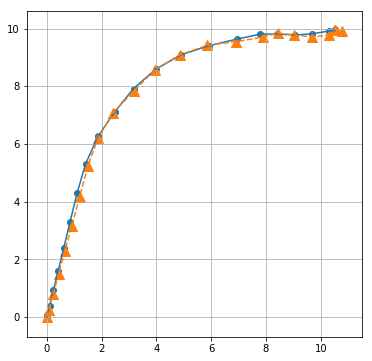

In [23]:
fig = plt.figure(figsize=(6,6))
plt.plot(x_train_.squeeze().detach().numpy()[:,0], x_train_.squeeze().detach().numpy()[:,1])
plt.plot(x_pred.squeeze().detach().numpy()[:,0], x_pred.squeeze().detach().numpy()[:,1],'--')
plt.scatter(x_train_.squeeze().detach().numpy()[:,0], x_train_.squeeze().detach().numpy()[:,1])
plt.scatter(x_pred.squeeze().detach().numpy()[:,0], x_pred.squeeze().detach().numpy()[:,1], marker='^', s=100)
plt.grid()



In [69]:
x_future, u_future = policy.propagate_n(T, x_train[:1,:,:])
complete_traj = policy.join_partial_future_signal(x_train[:1,:,:], x_future)

In [70]:
p = unstandardize_data(complete_traj, stats[0][:,:,:4], stats[1][:,:,:4]).detach()

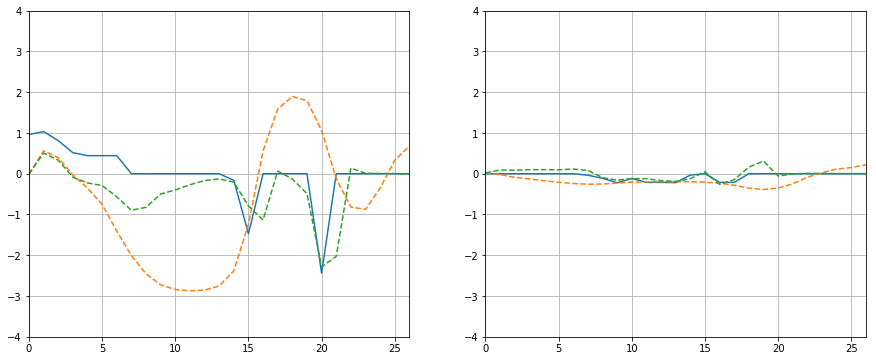

In [84]:
x_future, u_prop = policy.propagate_n(T, x_eval[:1,:,:])
o, u = policy(x_eval)
fig = plt.figure(figsize=(15,6))
for k in [0,1]:
    plt.subplot(1,2,k+1)
    plt.plot(u_eval_.squeeze().detach().numpy()[:,k])
    plt.plot(unstandardize_data(u_prop, stats[0][:,:,4:], stats[1][:,:,4:]).squeeze().detach().numpy()[:,k],'--')
    plt.plot(unstandardize_data(u, stats[0][:,:,4:], stats[1][:,:,4:]).squeeze().detach().numpy()[:,k],'--')

    plt.grid()
    plt.xlim([0, 26])
    plt.ylim([-4,4])


In [77]:
def foo(j):
    fig = plt.figure(figsize=(10,10))
    cov_env.draw2D(kwargs=draw_params)
    plt.axis("equal")
#     for j in range(ic_eval.shape[1]):
    plt.plot(traj_np[:,j,0], traj_np[:,j,1])
    plt.scatter(traj_np[:,j,0], traj_np[:,j,1])
    plt.xlim([-3, 12])
    plt.ylim([-3, 12])
    plt.scatter(x_train_.squeeze().numpy()[:,0], x_train_.squeeze().numpy()[:,1])
    plot_xy_from_tensor(p, fig)
    
interact(foo, j=widgets.IntSlider(min=0, max=ic_eval.shape[1]-1, step=1, value=10))

interactive(children=(IntSlider(value=10, description='j', max=127), Output()), _dom_classes=('widget-interact…

<function __main__.foo(j)>

In [12]:
def propagate_dynamics(dynamics, x0, us, stats=(torch.zeros([1,1,6]), torch.ones([1,1,6]))):
    xs = []
    xs.append(x0)
    for i in range(us.shape[0]):
        xs.append(dynamics(xs[-1], us[i:i+1,:,:], stats=stats))
    return torch.cat(xs, 0)

In [ ]:
class ExpertDemoDataset(torch.utils.data.Dataset):

    def __init__(self, npy_file):
        
        # [t, x, y, psi, V]
        self.data = np.load(npy_file)
        self.max_length = self.data.shape[0]


    def __len__(self):
        return data.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        time = self.data[idx, 0]
        state = np.zeros([self.max_length, 4])
        control = np.zeros([self.max_length, 2])
        state[:idx,:] = self.data[:idx, 1:5]
        control[:idx,:] = self.data[:idx, 5:7]
        
        
        return {'state': state, 'control': control, 'time': time, 'idx': idx}
    
    
def prepare_data(npy_file):
    # [t, x, y, psi, V, a, delta]
    data = np.load(npy_file)[:,1:]
    μ = np.mean(data, axis=0, keepdims=True)
    σ = np.std(data, axis=0, keepdims=True)
    x = torch.tensor(data[:, :4]).float().unsqueeze(1).requires_grad_(False)
    u = torch.tensor(data[:, 4:6]).float().unsqueeze(1).requires_grad_(False)
    return x, u, (torch.tensor(μ).float().unsqueeze(1).requires_grad_(False), torch.tensor(σ).float().unsqueeze(1).requires_grad_(False),)


def kinematic_bicycle(x, u, dt=0.5, stats=(torch.zeros([1,1,6]), torch.ones([1,1,2])), lr=0.7, lf=0.5, V_min=0.0, V_max=5.0, a_min=-3, a_max=3, delta_min=-0.344, delta_max=0.344):
    '''
    x is [..., state_dim]
    u is [..., ctrl_dim]
    '''
    μ = stats[0]
    σ = stats[1]
    # unscale
    x, y, psi, V = (x * σ[:,:,:4] + μ[:,:,:4]).split(1, dim=-1)
    a, delta = (u * σ[:,:,4:] + μ[:,:,4:]).split(1, dim=-1)

    beta = torch.atan(lr / (lr + lf) * torch.tan(delta.clamp(delta_min, delta_max)))
    
    psi_new = psi + 0.5 * a * dt**2 * torch.sin(beta) / lr + dt *V * torch.sin(beta) / lr
    V_new = (a.clamp(a_min, a_max)*dt + V).clamp(V_min, V_max)
    x_new = x - lr * torch.sin(beta + psi) / torch.cos(beta) + lr * torch.sin(beta + psi_new) / torch.cos(beta)
    y_new = y + lr * torch.cos(beta + psi) / torch.cos(beta) - lr * torch.cos(beta + psi_new) / torch.cos(beta)
    # scale
    return (torch.cat([x_new, y_new, psi_new, V_new], dim=-1) - μ[:,:,:4]) / σ[:,:,:4]


def initial_conditions(n):
    good_samples = np.zeros([1,2*n,4])
    total = 0
    while total < n:
        x0 = np.random.rand(1,n,4)
        x0[:,:,:2] -= 0.5
        x0[:,:,:2] *= 2.0
        x0[:,:,2] *= np.pi/4 + 3 * np.pi/4
        x0[:,:,3] *= 2
        p = torch.tensor(x0).float()
        v = vf(p).squeeze().numpy() < 0
        num_new = np.sum(v)
        good_samples[:,total:num_new+total,:] = x0[:,v,:]
        total += num_new
    return good_samples[:,:n,:]


class InitialConditionDataset(torch.utils.data.Dataset):

    def __init__(self, n):
        self.n = n
        self.ic = initial_conditions(n)


    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.ic[:,idx,:]
    
def standardize_data(x, mu, sigma):
    return (x - mu)/sigma

def unstandardize_data(x, mu, sigma):
    return x * sigma + mu



    
class STLPolicy(torch.nn.Module):

    def __init__(self, dynamics, state_dim, ctrl_dim, hidden_dim, stats, num_layers=1, dt = 0.5, a_min=-3, a_max=3, delta_min=-0.344, delta_max=0.344):
        super(STLPolicy, self).__init__()
        
        self.dynamics = dynamics
        self.stats = stats
        self.dt = dt      
        self.state_dim = state_dim

        a_lim_ = torch.tensor([a_min, a_max]).float().unsqueeze(0).unsqueeze(0)
        delta_lim_ = torch.tensor([delta_min, delta_max]).float().unsqueeze(0).unsqueeze(0)
        self.a_lim = standardize_data(a_lim_, stats[0][:,:,4:5], stats[1][:,:,4:5])
        self.delta_lim = standardize_data(delta_lim_, stats[0][:,:,5:], stats[1][:,:,5:])
        
        self.lstm = torch.nn.LSTM(state_dim, hidden_dim, num_layers)
        self.proj = torch.nn.Sequential(torch.nn.Linear(hidden_dim, ctrl_dim), torch.nn.Tanh())
        self.initialize_rnn = [torch.nn.Linear(state_dim, hidden_dim),  torch.nn.Linear(state_dim, hidden_dim)]
        self.L2loss = torch.nn.MSELoss()
        

    def switch_device(self, device):
        self.a_lim.to(device)
        self.delta_lim.to(device)
        self.stats[0].to(device)
        self.stats[1].to(device)

    def initial_rnn_state(self, x0):
        # x0 is [bs, state_dim]
        return [l(x0) for l in self.initialize_rnn]
    
    def forward(self, x):        
        # x is [time_dim, bs, state_dim]
        h0 = self.initial_rnn_state(x[:1,:,:])

        o, _ = self.lstm(x, h0)    # [time_dim, bs, hidden_dim] , bs = 1 for a single expert trajectory.
        
        # [time_dim, bs, ctrl_dim]  projecting between u_min and u_max (standardize) since proj is between -1 and 1 due to tanh
        u = (self.a_lim[:,:,1:] - self.a_lim[:,:,:1]) / 2 * self.proj(o) + self.a_lim.mean(-1, keepdims=True)
        return o, u
            
    
    def propagate_n(self, n, x_partial):
        '''
        n is the number of time steps to propagate forward
        x_partial is the input trajectory [time_dim, bs, state_dim]
        dynamics is a function that takes in x and u and gives the next state
        '''
        h0 = self.initial_rnn_state(x_partial[:1,:,:])

        x_future = []
        u_future = []
        
        o, h = self.lstm(x_partial, h0)    # h is the last hidden state/last output

        x_prev = x_partial[-1:, :,:]    # [1, bs, state_dim]

        for i in range(n):
            u_ = self.proj(h[0])    # [1, bs, ctrl_dim]
            u = (self.a_lim[:,:,1:] - self.a_lim[:,:,:1]) / 2 * u_ + self.a_lim.mean(-1, keepdims=True)
            u_future.append(u)
            x_next = self.dynamics(x_prev, u, stats=self.stats)    # [1, bs, state_dim]
            x_future.append(x_next)
            o, h = self.lstm(x_next, h)    # o, (h,c) are [1, bs, hidden_dim]

            x_prev = x_next
                
        return torch.cat(x_future, 0), torch.cat(u_future, 0)    # [n, bs, state_dim/ctrl_dim]
        
        
    def control_loss(self, x_partial, u_true):
        '''
        Encourage the policy to imitate the controls from the expert demonstration
        '''
        o, u = self.forward(x_partial)
        return self.L2loss(u, u_true)
    @staticmethod
    def join_partial_future_signal( x_partial, x_future):
        return torch.cat([x_partial, x_future], 0)
    
    def STL_loss_n(self, n, x_partial, formula, formula_input_func, **kwargs):
        '''
        Given partial trajectory, roll out the policy to get a complete trajectory.
        Encourage the complete trajectory to satisfy an stl formula
        '''
        x_future, u_future = self.propagate_n(n, x_partial)    # [n, bs, state_dim/ctrl_dim]
        x_complete = self.join_partial_future_signal(x_partial, x_future)
        signal = unstandardize_data(x_complete, self.stats[0][:,:,:self.state_dim], self.stats[1][:,:,:self.state_dim]).permute([1,0,2]).flip(1)    # [bs, time_dim, state_dim]
        return torch.relu(-formula.robustness(formula_input_func(signal), **kwargs)).mean()
    
    def STL_loss(self, x, formula, formula_input_func, **kwargs):
        signal = unstandardize_data(x, self.stats[0][:,:,:self.state_dim], self.stats[1][:,:,:self.state_dim]).permute([1,0,2]).flip(1)    # [bs, time_dim, state_dim]

        return torch.relu(-formula.robustness(formula_input_func(signal), **kwargs)).mean()
    
    def HJI_loss(self, x_traj):
        '''
        x is [time_dim, bs, state_dim]
        Given a trajectory, compute the integral (finite differencing) of the value function along the trajectory
        Want the value to be negative (more negative the better)
        '''
        
        total_value = vf(unstandardize_data(x_traj, self.stats[0][:,:,:self.state_dim], self.stats[1][:,:,:self.state_dim])).squeeze(-1).sum(0) * self.dt    # [time_dim, bs, 1]

        return torch.relu(total_value).mean()

In [ ]:
class HJIValueFunction(torch.autograd.Function):
        
    @staticmethod
    def forward(ctx, input):
        """
        [bs, x_dim]
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return value_interp(input.split(1, dim=-1))

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        points = input.split(1, dim=-1)
        gr = torch.zeros_like(input)
        dim = input.shape[-1]
#         IPython.embed(banner1="poop")

        return  torch.cat([deriv_interp[i](points) for i in range(dim)], -1) * grad_output
    
vf = HJIValueFunction.apply
